In [ ]:
! pip uninstall pulse2percept -y
! cd pulse2percept && pip install -r requirements.txt && pip install -r requirements-dev.txt && pip install -e .
! pip install tqdm 

In [7]:
! pip install Pillow
! pip install Pandas
! pip install sklearn

# Generating Datasets using python multiprocessing

In [1]:
import pulse2percept as p2p
from prima import * 
%matplotlib inline 
import matplotlib.pyplot as plt 

In [2]:
"""
    utilities for generating percepts for a given model/implant with one stimulus point at each pixel
    of magnitude 10
"""
from tqdm import tqdm 
from multiprocessing import Pool

BASE_CURRENT_CONSTANT = 10

def generate_dataset_helper(argpack):
    model, implant, stim_dim, idx = argpack
    stim = np.zeros(stim_dim)
    stim[idx] = BASE_CURRENT_CONSTANT
    implant.stim = stim
    percept = model.predict_percept(implant)
    return percept

def generate_dataset_fast(model, implant, stim_dim, j=8):
    with Pool(j) as p:
        generator = p.imap(generate_dataset_helper, [(model, implant, stim_dim, idx) for idx in range(0, stim_dim)])
        return list(tqdm(generator, total=stim_dim))


def plot_percept(ax, model, percept, title='Predicted percept'):
    ax.imshow(percept, cmap='gray')
    ax.set_xticks(np.linspace(0, percept.shape[1], num=5))
    ax.set_xticklabels(np.linspace(*model.xrange, num=5))
    ax.set_xlabel('x (dva)')
    ax.set_yticks(np.linspace(0, percept.shape[0], num=5))
    ax.set_yticklabels(np.linspace(*model.yrange, num=5))
    ax.set_ylabel('y (dva)')
    ax.set_title(title)
    

In [14]:
# utility for running PCA on some data 
from sklearn import decomposition
from sklearn import datasets
import numpy as np
import pandas as pd 
from sklearn.preprocessing import *

def run_pca(dataset, percentage=0.95):
    percepts = normalize(np.array([obj.flatten() for obj in dataset]))
    percepts_pca = decomposition.PCA(percentage)
    percepts_pca.fit(percepts)
    components = percepts_pca.transform(percepts)
    projected = percepts_pca.inverse_transform(components)
    return components, projected

In [ ]:
# example, generate percepts for ArgusII using AxonMapModel

# model = p2p.models.AxonMapModel(rho=100, axlambda=200)
# model.engine = 'serial'
# model.build()
# implant = p2p.implants.ArgusII()
# output_percepts = generate_dataset_fast(model, implant, 60)

# import pickle
# if output_percepts and len(output_percepts) > 0:
#     with open("./data/ArgusII_percepts.pickle", "wb") as f:
#         pickle.dump(output_percepts, f)

# print("Done generating percepts")

In [ ]:
# example, generate percepts for Prima using ScoreboardModel

# from prima import * 
# model = p2p.models.ScoreboardModel(rho=100)
# model.engine = 'serial'
# model.build()
# implant = Prima()
# output_percepts = generate_dataset_fast(model, implant, 400, j=12)
# if output_percepts:
#     with open("./data/Prima20x20_ScoreboardModel_percepts.pickle", "wb") as f:
#         pickle.dump(output_percepts, f)

## Dataset for Scoreboard w/Prima and Argus w/different values of rho

In [4]:
rhos = [25, 50, 75, 100, 125, 150, 200, 300]

In [ ]:
fig, axs = plt.subplots(len(rhos), 2, constrained_layout=False, figsize=(10, 4 * len(rhos)))

#
# PLOT THE ARGUS AND PRIMA IMPLANTS FOR VARIOUS VALUES OF RHO USING SCOREBOARD MODEL 
# SO THAT WE CAN VISUALIZE WHAT CHANGING VALUES FOR RHO DOES
#
for rho, (ax_argus, ax_prima) in zip(rhos, axs):
    model = p2p.models.ScoreboardModel(rho=rho)
    model.engine = 'serial'
    model.build()
    
    # simulate ArgusII
    print("rho: %d argus scoreboard" % rho)
    implant = p2p.implants.ArgusII()
    implant.stim = BASE_CURRENT_CONSTANT * np.ones(60)
    
    percept = model.predict_percept(implant)
    plot_percept(ax_argus, model, percept, "Argus w/rho: %d" % rho)
    
    # simulate ArgusII
    print("rho: %d prima scoreboard" % rho)
    implant = Prima()
    implant.stim = BASE_CURRENT_CONSTANT * np.ones(400)
    
    percept = model.predict_percept(implant)
    plot_percept(ax_prima, model, percept, "Prima w/rho: %d" % rho)

fig.tight_layout()

In [ ]:
import gzip
import pickle 
import os 
#
# GENERATE DATASET OF PERCEPTS FROM THE ABOVE PLOTTING
# !! WARNING !! THIS WILL TAKE A VERY LONG TIME ON MOST CPUs
#
basedir = "./data/changing_rho_experiments/"
try:
    os.makedirs(basedir)
except: pass 

print("generating percept sets for values of rho: " + str(rhos))
for rho in rhos:
    model = p2p.models.ScoreboardModel(rho=rho)
    model.engine = 'serial'
    model.build()
    
    # simulate ArgusII
    print("rho: %d argus scoreboard" % rho)
    if not os.path.exists(os.path.join(basedir, "argus_scoreboard_rho%d.pickle.gz" % rho)):
        implant = p2p.implants.ArgusII()
        percepts = generate_dataset_fast(model, implant, 60, j=12)
        with gzip.open(os.path.join(basedir, "argus_scoreboard_rho%d.pickle.gz" % rho), "wb") as f:
            pickle.dump(percepts, f)
            
    # simulate AlphaIMS
    print("rho: %d alphaims scoreboard" % rho)
    if not os.path.exists(os.path.join(basedir, "alphaims_scoreboard_rho%d.pickle.gz" % rho)):
        implant = p2p.implants.AlphaIMS()
        percepts = generate_dataset_fast(model, implant, 37 ** 2, j=12)
        with gzip.open(os.path.join(basedir, "alphaims_scoreboard_rho%d.pickle.gz" % rho), "wb") as f:
            pickle.dump(percepts, f)
    
    # simulate ArgusII
    print("rho: %d prima scoreboard" % rho)
    if not os.path.exists(os.path.join(basedir, "prima_scoreboard_rho%d.pickle.gz" % rho)):
        implant = Prima()
        percepts = generate_dataset_fast(model, implant, 400, j=12)
        with gzip.open(os.path.join(basedir, "prima_scoreboard_rho%d.pickle.gz" % rho), "wb") as f:
            pickle.dump(percepts, f)


generating percept sets for values of rho: [25, 50, 75, 100, 125, 150, 200, 300]
rho: 25 argus scoreboard
rho: 25 alphaims scoreboard



  3%|▎         | 36/1369 [06:11<1:09:41,  3.14s/it]

In [26]:
import pickle
import os 
import gzip 
# 
# GENERATE PLOT OF THE PCA DATA
#
percent = 0.95

argus_pca_shapes = []
prima_pca_shapes = []
for rho in rhos:
    argus_percepts_path = os.path.join(basedir, "argus_scoreboard_rho%d.pickle.gz" % rho)
    prima_percepts_path = os.path.join(basedir, "prima_scoreboard_rho%d.pickle.gz" % rho)
    with gzip.open(argus_percepts_path, "rb") as f:
        argus_percepts = pickle.load(f)
    print("loaded argus percepts for rho %d, size: %s" % (rho, str(np.array(argus_percepts).shape)))
    with gzip.open(prima_percepts_path, "rb") as f:
        prima_percepts = pickle.load(f)
    print("loaded prima percepts for rho %d, size: %s" % (rho, str(np.array(prima_percepts).shape)))
    
    argus_pca_components, _ = run_pca(argus_percepts, percent)
    argus_pca_shapes.append(argus_pca_components.shape)
    print("\targus pca shape: " + str(argus_pca_components.shape))
    prima_pca_components, _ = run_pca(prima_percepts, percent)
    prima_pca_shapes.append(prima_pca_components.shape)
    print("\tprima pca shape: " + str(prima_pca_components.shape))

loaded argus percepts for rho 25, size: (60, 124, 164)
loaded prima percepts for rho 25, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 378)
loaded argus percepts for rho 50, size: (60, 124, 164)
loaded prima percepts for rho 50, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 332)
loaded argus percepts for rho 75, size: (60, 124, 164)
loaded prima percepts for rho 75, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 175)
loaded argus percepts for rho 100, size: (60, 124, 164)
loaded prima percepts for rho 100, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 103)
loaded argus percepts for rho 125, size: (60, 124, 164)
loaded prima percepts for rho 125, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 68)
loaded argus percepts for rho 150, size: (60, 124, 164)
loaded prima percepts for rho 150, size: (400, 124, 164)
	argus pca shape: (60, 56)
	prima pca shape: (400

[378, 332, 175, 103, 68, 49, 30, 15]
[57, 57, 57, 57, 57, 56, 54, 44]


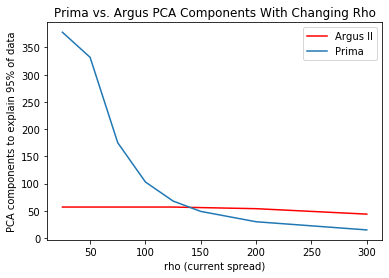

In [32]:
print([v[1] for v in prima_pca_shapes])
print([v[1] for v in argus_pca_shapes])
plt.plot(rhos, [v[1] for v in argus_pca_shapes], 'r', rhos, [v[1] for v in prima_pca_shapes])
plt.ylabel("PCA components to explain 95% of data")
plt.xlabel("rho (current spread)")
plt.title("Prima vs. Argus PCA Components With Changing Rho")
plt.legend(("Argus II", "Prima"))

In [ ]:
import pickle
import os 
import gzip 
# 
# GENERATE PLOT OF THE PCA DATA W/AXONMAP
#
percent = 0.95

argus_pca_shapes = []
prima_pca_shapes = []
for rho in rhos:
    argus_percepts_path = os.path.join(basedir, "argus_scoreboard_rho%d.pickle.gz" % rho)
    prima_percepts_path = os.path.join(basedir, "prima_scoreboard_rho%d.pickle.gz" % rho)
    with gzip.open(argus_percepts_path, "rb") as f:
        argus_percepts = pickle.load(f)
    print("loaded argus percepts for rho %d, size: %s" % (rho, str(np.array(argus_percepts).shape)))
    with gzip.open(prima_percepts_path, "rb") as f:
        prima_percepts = pickle.load(f)
    print("loaded prima percepts for rho %d, size: %s" % (rho, str(np.array(prima_percepts).shape)))
    
    argus_pca_components, _ = run_pca(argus_percepts, percent)
    argus_pca_shapes.append(argus_pca_components.shape)
    print("\targus pca shape: " + str(argus_pca_components.shape))
    prima_pca_components, _ = run_pca(prima_percepts, percent)
    prima_pca_shapes.append(prima_pca_components.shape)
    print("\tprima pca shape: " + str(prima_pca_components.shape))